# ARCH Model

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bs4 as bs
import requests
from random import randrange

import yfinance as yf # not sure why but it seems VSCode needs yfinance to be imported again
import arch.data.sp500
from arch import arch_model

from arch.univariate import GeneralizedError, EGARCH, ARX, Normal, HARX

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [2]:
# Example: we can get data on the S&P500 index and compute the daily returns (a percentage)
data = arch.data.sp500.load()
market = data["Adj Close"]
returns = 100 * market.pct_change().dropna()

In [3]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-01-04,1229.229980,1248.810059,1219.099976,1228.099976,1228.099976,877000000
1999-01-05,1228.099976,1246.109985,1228.099976,1244.780029,1244.780029,775000000
1999-01-06,1244.780029,1272.500000,1244.780029,1272.339966,1272.339966,986900000
1999-01-07,1272.339966,1272.339966,1257.680054,1269.729980,1269.729980,863000000
1999-01-08,1269.729980,1278.239990,1261.819946,1275.089966,1275.089966,937800000
...,...,...,...,...,...,...
2018-12-24,2400.560059,2410.340088,2351.100098,2351.100098,2351.100098,2613930000
2018-12-26,2363.120117,2467.760010,2346.580078,2467.699951,2467.699951,4233990000
2018-12-27,2442.500000,2489.100098,2397.939941,2488.830078,2488.830078,4096610000


In [4]:
# Create a Ticker object
apple_ticker = yf.Ticker("AAPL")

# Fetch historical market data
apple_historical_data = apple_ticker.history(period="max") # data for the entire history of Apple
print("Historical Data:")
apple_historical_data.tail()

Historical Data:


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-01-28 00:00:00-05:00,230.850006,240.190002,230.809998,238.259995,75707600,0.0,0.0
2025-01-29 00:00:00-05:00,234.119995,239.860001,234.009995,239.360001,45486100,0.0,0.0
2025-01-30 00:00:00-05:00,238.669998,240.789993,237.210007,237.589996,55658300,0.0,0.0
2025-01-31 00:00:00-05:00,247.190002,247.190002,233.440002,236.000000,100959800,0.0,0.0
2025-02-03 00:00:00-05:00,229.440002,231.830002,225.710007,228.009995,70078180,0.0,0.0


In [5]:
apple_historical_data.shape

(11126, 7)

In [6]:
# all data up to the end of 2023
apple_historical_data[:'2023-12-31']

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1980-12-12 00:00:00-05:00,0.098834,0.099264,0.098834,0.098834,469033600,0.0,0.0
1980-12-15 00:00:00-05:00,0.094108,0.094108,0.093678,0.093678,175884800,0.0,0.0
1980-12-16 00:00:00-05:00,0.087232,0.087232,0.086802,0.086802,105728000,0.0,0.0
1980-12-17 00:00:00-05:00,0.088951,0.089381,0.088951,0.088951,86441600,0.0,0.0
1980-12-18 00:00:00-05:00,0.091530,0.091959,0.091530,0.091530,73449600,0.0,0.0
...,...,...,...,...,...,...,...
2023-12-22 00:00:00-05:00,194.228473,194.457363,192.029255,192.656189,37122800,0.0,0.0
2023-12-26 00:00:00-05:00,192.666124,192.944757,191.889928,192.108856,28919300,0.0,0.0
2023-12-27 00:00:00-05:00,191.551588,192.556659,190.158404,192.208359,48087700,0.0,0.0


In [46]:
# scaling the closing prices
#Gabby's note - it doesn't make sense to do this, because StandardScalers tend to help normalizing over multiple features with different units, and we are only concerned with close price
'''
scale = StandardScaler()
apple_historical_data['Close_Scaled'] = scale.fit_transform(apple_historical_data[['Close']])
'''

In the following code, we make training and testing datasets from Apple's historical data and then fit GARCH models with parameters $p,q$ ranging from 1 to 5. We compare each of their forecasts to a rolling volatility (with window of size 5) and then look for the best parameters. We use data prior to Dec 1 2023 for our training set, and beyond Dec 1 2023 for our test set.

In [7]:
train = apple_historical_data[:'2023-12-01 00:00:00-05:00']['Close'] # for options pricing, we want the volatility of the underlying stock, not the returns
test = apple_historical_data['2023-12-01 00:00:00-05:00':]['Close']

In [23]:
train.head()

Date
1980-12-12 00:00:00-05:00    0.098834
1980-12-15 00:00:00-05:00    0.093678
1980-12-16 00:00:00-05:00    0.086802
1980-12-17 00:00:00-05:00    0.088951
1980-12-18 00:00:00-05:00    0.091530
Name: Close, dtype: float64

In [117]:
realized_vol = test.rolling(window=5).std().dropna()

# Initialize variables to store results
results = []
best_model = None
best_mse = float('inf')
rs = 98

# Loop over p and q in range(1, 6)
for p in range(4, 6):
    for o in range(3,5):
        for q in range(6, 8):
            try:
                # Fit an EGARCH(p, o, q) model wirh generalized error and ARX mean model
                dist = Normal(seed=rs)#GeneralizedError(seed=rs)
                vol = EGARCH(p=p, o=o, q=q) #No asymmetric innovation (cycle over o to test if this can improve predictions)
                model = HARX(train.values, lags=20, volatility=vol, distribution=dist) #Autoregressive prediction of returns can capture growth

                #model = arch_model(train, vol='Garch', p=p, q=q, dist='Normal')
                model_fit = model.fit(disp="off")
                
                # Forecast for the test period
                forecast = model_fit.forecast(horizon=len(test), method='simulation')
                close_predictions = forecast.simulations
                # Because the rolling window has to drop some NaN values, we need to align forecast length here
                forecast_vol = np.sqrt(forecast.variance.iloc[-1][:len(realized_vol)])
                
                # Calculate MSE
                mse = np.mean((realized_vol.values - forecast_vol.values) ** 2)#np.mean((close_predictions.values-test.values)**2)
                
                # Store results
                results.append({'p': p, 'o': o, 'q': q, 'MSE': mse})
                
                # Track the best model
                if mse < best_mse:
                    best_mse = mse
                    best_model = model_fit
                    #print(f'best model is p={p}, o={o}, q={q}')
            
            except Exception as e:
                print(f"Error with p={p}, o={o}, q={q}: {e}")

# Convert results to a DataFrame for easier inspection
results_df = pd.DataFrame(results)

# Print and sort results by MSE
print("Best models sorted by MSE:")
print(results_df.sort_values(by='MSE').head())

/Users/gabbyhuckabee/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/gabbyhuckabee/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/gabbyhuckabee/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/gabbyhuckabee/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warning

Best models sorted by MSE:
   p  o  q          MSE
6  5  4  6  1623.417000
5  5  3  7  1624.662051
7  5  4  7  1630.428484
4  5  3  6  1668.632961
3  4  4  7  1838.709570


/Users/gabbyhuckabee/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [124]:
forecasttest = best_model.forecast(horizon=len(test), method='simulation')
close_predictions = forecasttest.mean.values.reshape([293,])
close_variance = np.sqrt(forecasttest.variance.values.reshape([293,]))

# Because the rolling window has to drop some NaN values, we need to align forecast length here
forecast_vol = np.sqrt(forecasttest.variance.iloc[-1][:len(realized_vol)])


mse = np.mean((realized_vol.values - forecast_vol.values) ** 2)

print(mse)
print(forecasttest.simulations.values)
print(forecasttest.simulated_residuals)

1682.5098844128383
[[[191.11137867 188.38131318 191.64198645 ... 248.754753   245.65923666
   243.33586139]
  [191.07251921 190.11330032 189.25028552 ... 324.06639469 320.35420075
   313.31818547]
  [189.57612266 187.52081119 186.58080911 ... 325.58880096 324.497206
   322.19112165]
  ...
  [192.12504494 189.99889556 193.13110231 ... 300.31081204 299.5092912
   301.38199169]
  [189.96316493 188.60803218 189.5993681  ... 258.43155014 259.28690698
   257.7629043 ]
  [186.89537651 186.82590654 187.81560969 ... 294.77682999 279.94273427
   288.35190704]]]
[[[  0.58282557  -2.96010876   3.08690714 ...  -0.80865522  -3.04720264
    -2.48692362]
  [  0.54396611  -1.1882206   -1.08505538 ...   5.1027264   -4.31898617
    -7.35296565]
  [ -0.95243043  -2.24420492  -1.1638566  ...   0.08849854  -1.55152351
    -2.63458876]
  ...
  [  1.59649185  -2.38336219   2.96338383 ...   8.03681494  -0.71427398
     1.60178757]
  [ -0.56538816  -1.55440019   0.75678234 ...   1.65960432   0.69526796
    -1.8

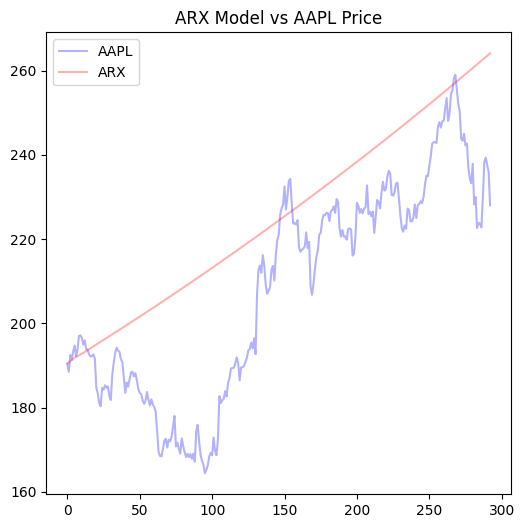

In [119]:
# Plot closing price predictions vs actual values
plt.figure(figsize=(6, 6))
plt.plot(test.values, color = 'b', alpha = 0.3, label='AAPL')
plt.plot(close_predictions, color = 'r', alpha = 0.3, label='ARX')
#plt.xlabel('Date')
plt.legend()

plt.title('ARX Model vs AAPL Price')
#plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()

Let's do the above again but now put into a function that takes in a ticker and gives the hyperparameters for a GARCH model that returns the best MSE.

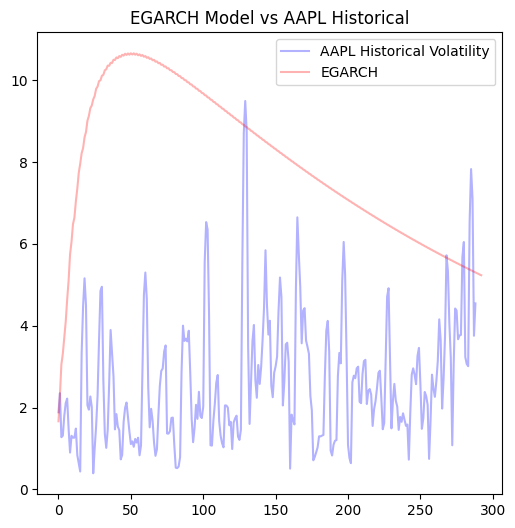

In [116]:
# Plot closing price variance vs actual historical volatility
plt.figure(figsize=(6, 6))
plt.plot(realized_vol.values, color = 'b', alpha = 0.3, label='AAPL Historical Volatility')
plt.plot(close_variance, color = 'r', alpha = 0.3, label='EGARCH')
#plt.xlabel('Date')
plt.legend()

plt.title('EGARCH Model vs AAPL Historical')
#plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()

In [9]:
def bestModel(ticker,date, metric, Window,P,Q):
    """
    Input:
    ticker = str, a stock ticker
    date = 'YYYY-MM-DD' for the cut off date on the training data
    metric = str; open, close, volume, etc
    Window = int, sliding window size
    P = list of positive integers, range of parameters for GARCH
    Q = list of positive integers, range of parameters for GARCH
    """
    # Create a Ticker object
    tick = yf.Ticker(ticker)

    # Fetch historical market data
    historical_data = tick.history(period="max") # data for the entire history of Apple

    #scale = StandardScaler()
    #historical_data[metric + '_Scaled'] = scale.fit_transform(historical_data[[metric]])

    train = historical_data[:date][metric]# + '_Scaled'] # for options pricing, we want the volatility of the underlying stock, not the returns
    test = historical_data[date:][metric]# + '_Scaled']

    realized_vol = test.rolling(window=Window).std().dropna()

    # Initialize variables to store results
    results = []
    best_model = None
    best_mse = float('inf')

    # Loop over p and q in range(1, 6)
    for p in P:
        for q in Q:
            try:
                # Fit a GARCH(p, q) model
                model = arch_model(train, vol='Garch', p=p, q=q, dist='Normal')
                model_fit = model.fit(disp="off")
                
                # Forecast for the test period
                forecast = model_fit.forecast(horizon=len(test))
                # Because the rolling window has to drop some NaN values, we need to align forecast length here
                forecast_vol = np.sqrt(forecast.variance.iloc[-1][:len(realized_vol)])
                
                # Calculate MSE
                mse = np.mean((realized_vol.values - forecast_vol.values) ** 2)
                
                # Store results
                results.append({'p': p, 'q': q, 'MSE': mse})
                
                # Track the best model
                if mse < best_mse:
                    best_mse = mse
                    best_model = model_fit
            
            except Exception as e:
                print(f"Error with p={p}, q={q}: {e}")

    # Convert results to a DataFrame for easier inspection
    results_df = pd.DataFrame(results)
    sorted_results = results_df.sort_values(by='MSE')

    best_p = int(sorted_results.iloc[0]['p'])
    best_q = int(sorted_results.iloc[0]['q'])

    model = arch_model(train, vol='Garch', p=best_p, q=best_q, dist='Normal')

    # Print and sort results by MSE
    print("Best models sorted by MSE")
    print(sorted_results)
    return model    

In [10]:
best_model = bestModel('AAPL','2023-12-31', 'Close', 5,[2,3,4],[2,3,4])

/Users/gabbyhuckabee/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/gabbyhuckabee/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/gabbyhuckabee/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
/Users/gabbyhuckabee/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.op

Best models sorted by MSE
   p  q           MSE
4  3  3  4.816084e-02
1  2  3  2.795721e-01
5  3  4  2.113167e+00
3  3  2  1.392076e+01
8  4  4  1.396679e+01
0  2  2  1.430995e+01
7  4  3  2.622367e+01
6  4  2  3.834498e+01
2  2  4  1.940766e+09


In [11]:
realized_vol = test.rolling(window=5).std().dropna()

best_model_fit = best_model.fit()

# Forecast for the test period
forecast = best_model_fit.forecast(horizon=len(test))
# Because the rolling window has to drop some NaN values, we need to align forecast length here
forecast_vol = np.sqrt(forecast.variance.iloc[-1][:len(realized_vol)])

# Calculate MSE
print(np.mean((realized_vol.values - forecast_vol.values) ** 2))

Iteration:      1,   Func. Count:     10,   Neg. LLF: 4163117211.0407815
Iteration:      2,   Func. Count:     29,   Neg. LLF: 36732.71682387289
Iteration:      3,   Func. Count:     39,   Neg. LLF: 307665.1941628094
Iteration:      4,   Func. Count:     49,   Neg. LLF: 3474891296.3083334
Iteration:      5,   Func. Count:     68,   Neg. LLF: 52208.919483876205
Iteration:      6,   Func. Count:     81,   Neg. LLF: 35996.89839092626
Iteration:      7,   Func. Count:     91,   Neg. LLF: 15335.891190763698
Iteration:      8,   Func. Count:    100,   Neg. LLF: 135824.43490017668
Iteration:      9,   Func. Count:    116,   Neg. LLF: 21319.535323030534
Iteration:     10,   Func. Count:    126,   Neg. LLF: 75617.55195026961
Iteration:     11,   Func. Count:    141,   Neg. LLF: 10638540004.009874
Iteration:     12,   Func. Count:    160,   Neg. LLF: 82734.77230301197
Iteration:     13,   Func. Count:    173,   Neg. LLF: 130949.80154930199
Iteration:     14,   Func. Count:    183,   Neg. LLF: 67

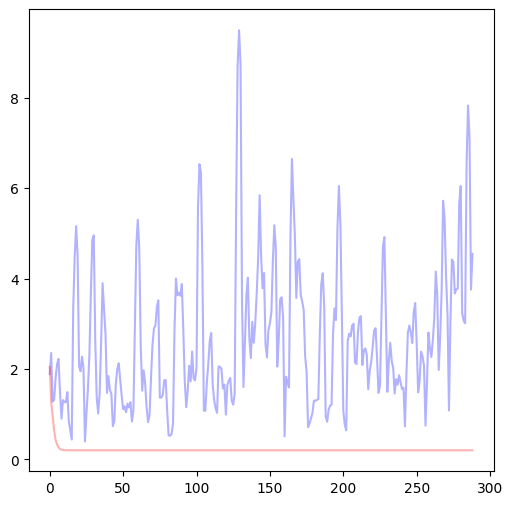

In [14]:
# Plot daily closing price
plt.figure(figsize=(6, 6))
plt.plot(realized_vol.values, color = 'b', alpha = 0.3)
plt.plot(forecast_vol.values, color = 'r', alpha = 0.3)
#plt.xlabel('Date')

#plt.title('Rolling Volatility (n=30)')
#plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()

The MSE don't match but there is some inherent randomness in the model.

The above code should be easily modified if we want to try EGARCH or TARCH. For example, first import:
`from arch.univariate import EGARCH`

The code below scrapes Wikipedia for a list of the S&P500 companies and then gives a way to randomly select a ticker and get data on it from Yahoo Finance.

In [55]:
def get_tickers():
    
    # Scrape the Wikipedia page related to the S&P500 
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable sticky-header'})
    tickers = []

    # Import stock tickers
    for row in table.findAll('tr')[2:]: 
        ticker_info = (row.findAll('td')[0].text.replace('\n', ''), row.findAll('td')[1].text, row.findAll('td')[2].text)
        tickers.append(ticker_info)
    
    return tickers

In [56]:
list = get_tickers()
list

[('AOS', 'A. O. Smith', 'Industrials'),
 ('ABT', 'Abbott Laboratories', 'Health Care'),
 ('ABBV', 'AbbVie', 'Health Care'),
 ('ACN', 'Accenture', 'Information Technology'),
 ('ADBE', 'Adobe Inc.', 'Information Technology'),
 ('AMD', 'Advanced Micro Devices', 'Information Technology'),
 ('AES', 'AES Corporation', 'Utilities'),
 ('AFL', 'Aflac', 'Financials'),
 ('A', 'Agilent Technologies', 'Health Care'),
 ('APD', 'Air Products', 'Materials'),
 ('ABNB', 'Airbnb', 'Consumer Discretionary'),
 ('AKAM', 'Akamai Technologies', 'Information Technology'),
 ('ALB', 'Albemarle Corporation', 'Materials'),
 ('ARE', 'Alexandria Real Estate Equities', 'Real Estate'),
 ('ALGN', 'Align Technology', 'Health Care'),
 ('ALLE', 'Allegion', 'Industrials'),
 ('LNT', 'Alliant Energy', 'Utilities'),
 ('ALL', 'Allstate', 'Financials'),
 ('GOOGL', 'Alphabet Inc. (Class A)', 'Communication Services'),
 ('GOOG', 'Alphabet Inc. (Class C)', 'Communication Services'),
 ('MO', 'Altria', 'Consumer Staples'),
 ('AMZN',

In [57]:
# Pick a random stock (without repetition) from a list
def random_picker(list):   
    i = randrange(len(list))
    random_stock = list[i]
    
    return random_stock

In [58]:
random_picker(list)

('INTU', 'Intuit', 'Information Technology')

In [59]:
# Get n stocks from S&P500, some dataframes are empty
n=10
k=0
period = '1y'
prices = []
stock_names=[]
stock_symbols=[]
while k<n:
    name = random_picker(list)
    ticker = yf.Ticker(name[0])
    stock_prices = ticker.history(period=period)
    if not stock_prices.empty:
        stock_names.append(name)
        stock_symbols.append(name[0])
        prices.append(stock_prices)
        k+=1

In [60]:
stock_names

[('AAPL', 'Apple Inc.', 'Information Technology'),
 ('HD', 'Home Depot (The)', 'Consumer Discretionary'),
 ('CPRT', 'Copart', 'Industrials'),
 ('SHW', 'Sherwin-Williams', 'Materials'),
 ('EG', 'Everest Group', 'Financials'),
 ('MCK', 'McKesson Corporation', 'Health Care'),
 ('FFIV', 'F5, Inc.', 'Information Technology'),
 ('MOH', 'Molina Healthcare', 'Health Care'),
 ('MOH', 'Molina Healthcare', 'Health Care'),
 ('FOX', 'Fox Corporation (Class B)', 'Communication Services')]

In [61]:
# combines columns labeled 'Value' from dataframes that are placed in a list (so each dataframe needs 'Value' as a column)
# adds an average value column and also daily return % column

def combine(prices,value):
    # Concatenate the value columns
    combined = pd.concat([df[value] for df in prices], axis=1)

    combined.columns = stock_symbols

    combined = combined.dropna(axis=1)

    # Calculate the average value price for each day
    combined['Average_' + value] = combined.mean(axis=1)
    combined['Daily Returns %'] = ((combined['Average_'+value]/combined['Average_'+value].shift(1))-1)*100
    return combined

In [62]:
combined = combine(prices,'Close')
combined.head()

,AAPL,HD,CPRT,SHW,EG,MCK,FFIV,MOH,MOH,FOX,Average_Close,Daily Returns %
Date,,,,,,,,,,,,
2024-01-03 00:00:00-05:00,183.351746,331.911560,46.830002,294.846375,358.579834,478.096527,174.089996,376.670013,376.670013,27.499664,264.854573,NaN
2024-01-04 00:00:00-05:00,181.023163,332.235382,46.639999,293.852875,362.264648,472.333588,171.779999,378.739990,378.739990,27.519327,264.512896,-0.129005
2024-01-05 00:00:00-05:00,180.296707,336.503723,46.549999,294.756989,365.929779,475.956604,171.449997,378.589996,378.589996,27.627480,265.625127,0.420483
2024-01-08 00:00:00-05:00,184.655365,341.400055,47.340000,297.528900,367.003662,474.403870,174.679993,377.769989,377.769989,28.001087,267.055291,0.538414
2024-01-09 00:00:00-05:00,184.237411,339.692749,47.279999,295.581573,363.072540,478.813171,174.080002,380.459991,380.459991,27.696302,267.137373,0.030736


Let's now find the best GARCH parameters for a random ticker from S&P500. Hopefully, the company has existed long enough for the chosen date to make sense.

In [64]:
tick = random_picker(list)
print(tick)

('EQR', 'Equity Residential', 'Real Estate')


In [65]:
best_model = bestModel(tick[0],'2023-12-31', 'Close', 5,[2,3,4],[2,3,4])

Best models sorted by MSE
   p  q       MSE
1  2  3  0.126484
4  3  3  0.377302
2  2  4  0.792294
0  2  2  0.957579
8  4  4  4.839082
3  3  2  4.848723
5  3  4  5.392088
6  4  2  5.489939
7  4  3  9.891386
